In [3]:
# Pandas feels like excel in Python
# NumPy for numerical work 
#  Matplot and Seaborn for charts 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
#reading the data into dataframe, data seperated by semicolon 
#Time series data requires certain formating, need first colum to be date and time togther, so we combined "date" and "time" 
#missing data is ?, need to treat ? as a missign value

df = pd.read_csv(
    "household_power_consumption.csv",
    sep=";",
    parse_dates={"datetime": ["Date", "Time"]},
    dayfirst=True,
    na_values=["?"]
)

# Into "datetime", setting it as index of our datafram - every row lines up with an moment in time (1 min increments) 
df = df.set_index("datetime")


/var/folders/63/8p127jbx2nzglm6p7pyrntbr0000gn/T/ipykernel_9347/150992506.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


In [5]:
df = df.astype(float) #converting all data to float types for numeric work 


In [6]:
#drop an data with missing values 
df = df.dropna()


In [7]:
# data exploration, descriptive statistics of our variables 
df.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


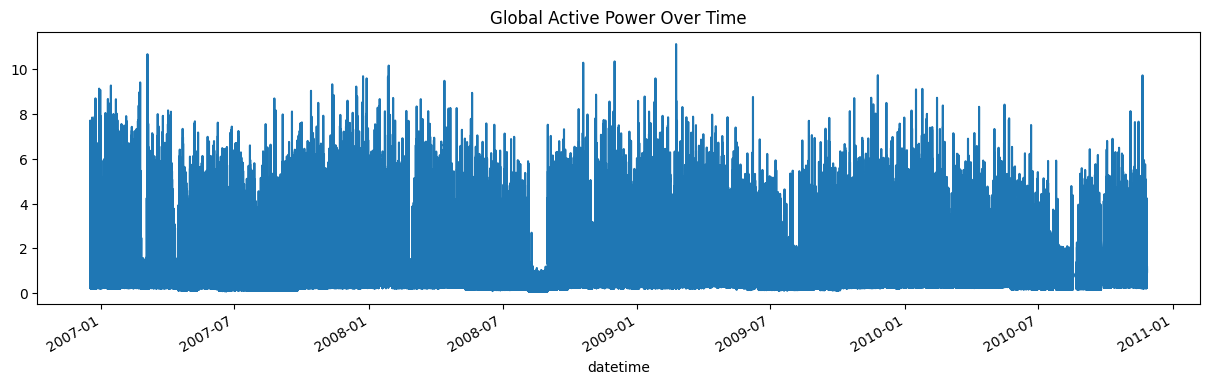

In [8]:
# Global Active Power over time Graph 

df['Global_active_power'].plot(figsize=(15,4))
plt.title("Global Active Power Over Time")
plt.show()


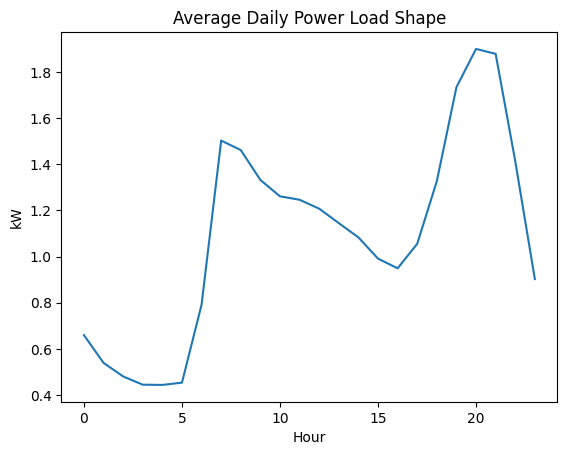

In [9]:
# Average the power use by hour of the day to see the typical daily shape (more power at night vs morning?).
df.groupby(df.index.hour)['Global_active_power'].mean().plot()
plt.title("Average Daily Power Load Shape")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.show()


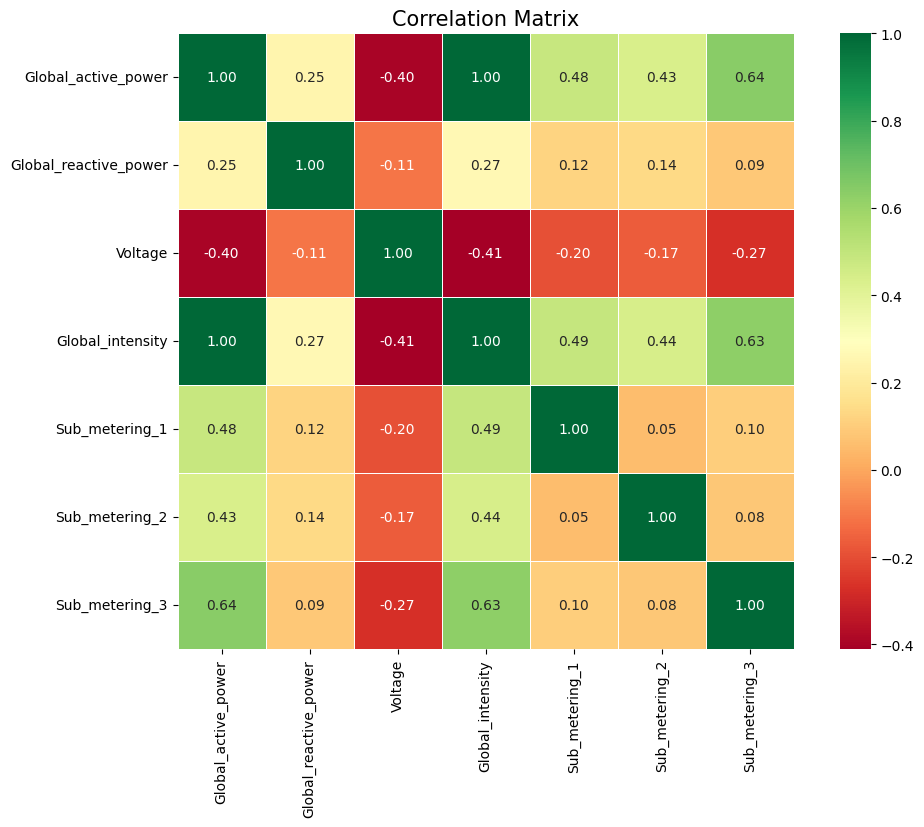

In [10]:
# corellation matrixz Heatmap
 
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="RdYlGn", annot=True, fmt=".2f",
            linewidths=.5, square=True)
plt.title("Correlation Matrix", fontsize=15)
plt.show()


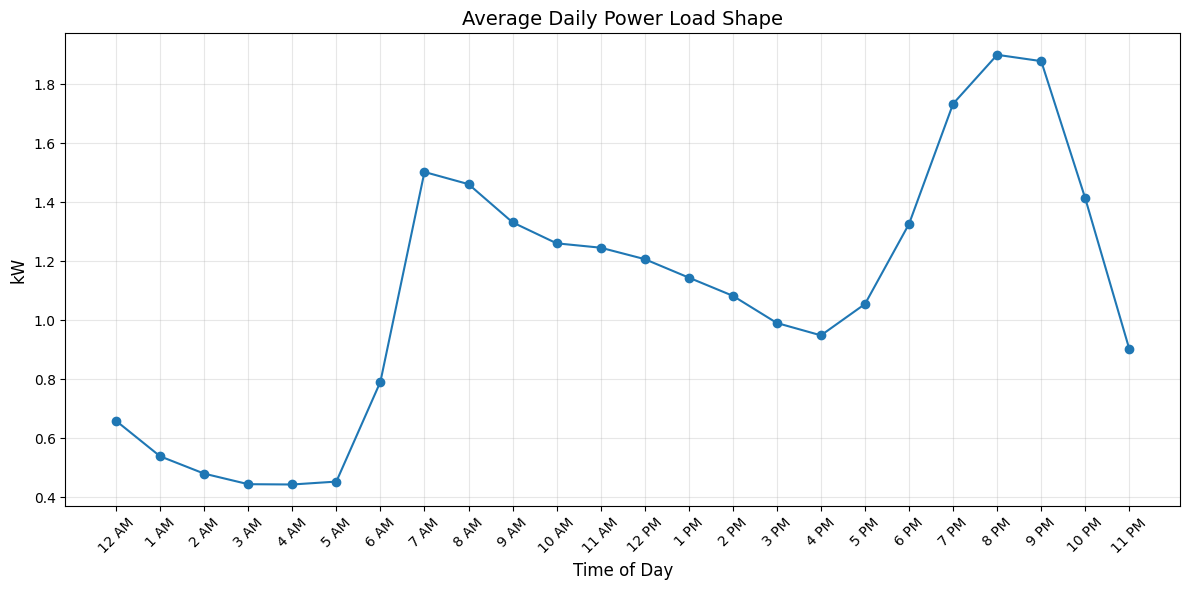

In [11]:
# Compute the average power for each hour so we can draw a smoother, friendlier chart.
hourly_avg = df['Global_active_power'].groupby(df.index.hour).mean()

plt.figure(figsize=(12,6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')

plt.title("Average Daily Power Load Shape", fontsize=14)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("kW", fontsize=12)

# Time labels am and pm 
ampm_labels = [
    "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
    "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
]

plt.xticks(ticks=range(24), labels = ampm_labels, rotation = 45, fontsize = 10)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Keep the rows in time order so any lags features make sense

df = df.sort_index()

# Create time-based features that might help the model learn patterns

df["hour"] = df.index.hour                 # 0–23 hours of day, first hour is 0 
df["minute"] = df.index.minute             # 0–59 minutes of hour 
df["dayofweek"] = df.index.dayofweek      # Monday = 0  Sunday = 6 
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 = Sat or Sun, else 0

#creeate "lag" columns that say what the power looked like a minute, an hour, or a full day ago, see if electricy demand in past helps predict current demand 
#shift method moves data down by the specified number of rows, so each row shows the value from that many minutes ago

df["lag_1min"] = df["Global_active_power"].shift(1)      # 1 minute ago
df["lag_1hr"] = df["Global_active_power"].shift(60)      # 1 hour ago
df["lag_6hr"] = df["Global_active_power"].shift(360)     # 6 hours ago
df["lag_24hr"] = df["Global_active_power"].shift(1440)  # 24 hours ago

# Created rolling average features to capture recent trends
#rolling method creates a moving window over the data, mean method calculates average within that window

df["avg_15min"] = df["Global_active_power"].rolling(window=15).mean()
df["avg_60min"] = df["Global_active_power"].rolling(window=60).mean()
df["avg_6hr"] = df["Global_active_power"].rolling(window=360).mean()
df["avg_24hr"] = df["Global_active_power"].rolling(window=1440).mean()

# Power factor is a efficently mesure  closer to 1 means we are using power cleanly instead of wasting it.
df["power_factor"] = df["Global_active_power"] / np.sqrt(df["Global_active_power"]** 2 + df["Global_reactive_power"]** 2)


df = df.dropna() #drop any rows with missing values created by lag/rolling features


df.head() # take a look at new features 


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,minute,dayofweek,is_weekend,lag_1min,lag_1hr,lag_6hr,lag_24hr,avg_15min,avg_60min,avg_6hr,avg_24hr,power_factor
datetime,,,,,,,,,,,,,,,,,,,,
2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,17,24,6,1,3.238,4.864,3.834,4.216,3.579600,3.527967,2.485928,2.487154,0.998745
2006-12-17 17:25:00,3.360,0.164,231.20,14.4,0.0,0.0,16.0,17,25,6,1,3.390,4.868,3.810,5.360,3.566533,3.502833,2.484678,2.485765,0.998811
2006-12-17 17:26:00,3.400,0.162,232.86,14.6,0.0,0.0,17.0,17,26,6,1,3.360,4.876,3.824,5.374,3.552933,3.478233,2.483500,2.484394,0.998867
2006-12-17 17:27:00,3.396,0.164,232.89,14.6,0.0,0.0,17.0,17,27,6,1,3.400,4.810,3.838,5.388,3.530800,3.454667,2.482272,2.483011,0.998836
2006-12-17 17:28:00,3.282,0.100,232.33,14.0,0.0,0.0,16.0,17,28,6,1,3.396,4.790,3.844,3.666,3.502933,3.429533,2.480711,2.482744,0.999536


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor\





In [14]:
#Train Test Split 

# Define forecast futures in min  so we can create the targets the models our model will predict 
forecast = {
    'target_15min': 15,
    'target_1hr': 60,
    'target_6hr': 360,
    'target_24hr': 1440}

for target_name, minutes_ahead in forecast.items():
    df[target_name] = df['Global_active_power'].shift(-minutes_ahead)


# Drop any rows that could not create a forecast target 
model_df = df.dropna(subset = list(forecast.keys())).copy()

max_rows = 100_000  # adjust up to 2 mil, neeed less rows computer crashes


if len(model_df) > max_rows:
    model_df = model_df.iloc[-max_rows:]
    
feature_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'minute', 'dayofweek', 'is_weekend',
    'lag_1min', 'lag_1hr', 'lag_6hr', 'lag_24hr',
    'avg_15min', 'avg_60min', 'avg_6hr', 'avg_24hr', 'power_factor']

# chronologically ordered so lag can work 
train_data, val_data = train_test_split(model_df, test_size=0.2,shuffle=False)

X_train = train_data[feature_cols]
X_val = val_data[feature_cols]

print(f"Train samples: {len(X_train)}")
print(f"Val samples: {len(X_val)}")


Train samples: 80000
Val samples: 20000


In [15]:
# Random Forest Model across horizons

horizon_labels = {
    'target_1hr': '1-hour',
    'target_6hr': '6-hour',
    'target_24hr': '24-hour'
}

rf_results = {}

for target_name, label in horizon_labels.items():
    y_train = train_data[target_name]
    y_val = val_data[target_name]

    rf_model = RandomForestRegressor(
        n_estimators = 300,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 3,
        random_state = 42,
        n_jobs = -1
    )

    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_val)

    rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
    mae_rf = mean_absolute_error(y_val, y_pred_rf)
    r2_rf = r2_score(y_val, y_pred_rf)
    mape_rf = (np.abs(y_val - y_pred_rf) / np.abs(y_val)).mean() * 100

    rf_results[label] = {
        'rmse': rmse_rf,
        'mae': mae_rf,
        'mape': mape_rf,
        'r2': r2_rf,
        'model': rf_model,}

    print(f"Random Forest Results ({label} horizon)")
    print(f"RMSE: {rmse_rf} kW")
    print(f"MAE:  {mae_rf} kW")
    print(f"MAPE: {mape_rf} %")
    print(f"R^2:  {r2_rf}")


Random Forest Results (1-hour horizon)
RMSE: 0.7580414694182482 kW
MAE:  0.5151217408724807 kW
MAPE: 70.15701033091133 %
R^2:  0.397326379611744
Random Forest Results (6-hour horizon)
RMSE: 0.9477222246507192 kW
MAE:  0.6310479573888772 kW
MAPE: 92.2831139717315 %
R^2:  0.05535464836687454
Random Forest Results (24-hour horizon)
RMSE: 0.8817772718758435 kW
MAE:  0.6224353764038989 kW
MAPE: 90.5212747514766 %
R^2:  0.17096727696178693


In [ ]:
# histogram, Gradient boosting t model across horizons 
from sklearn.ensemble import HistGradientBoostingRegressor


hgb_results = {}

max_depth_list = [4, 8]
learning_rate_list = [0.05, 0.1]
max_iter_list = [300, 600]
l2_list = [0.0, 0.1]

for target_name, label in horizon_labels.items():
    y_train = train_data[target_name]
    y_val = val_data[target_name]

    best_rmse = float('inf')
    best = None

    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for max_iter in max_iter_list:
                for l2 in l2_list:
                    model = HistGradientBoostingRegressor(
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        max_iter= max_iter,
                        l2_regularization= l2,
                    random_state = 42,
                    )
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)

                    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                    mae = mean_absolute_error(y_val, y_pred)
                    r2 = r2_score(y_val, y_pred)
                    denom = np.where(np.abs(y_val) < 1e-6, np.nan, np.abs(y_val))
                    mape = np.nanmean(np.abs(y_val - y_pred) / denom) * 100

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best = {
                            'rmse': rmse,
                            'mae': mae,
                            'mape': mape,
                            'r2': r2,
                            'params': {
                                'max_depth': max_depth,
                                'learning_rate': learning_rate,
                                'max_iter': max_iter,
                                'l2_regularization': l2,
                            },
                            'model': model,
                        }

    hgb_results[label] = best
    print(f"HGB ({label})")
    print(f"RMSE: {best['rmse']:.3f} kW")
    print(f"MAE:  {best['mae']:.3f} kW")
    print(f"MAPE: {best['mape']:.1f} %")
    print(f"R^2:  {best['r2']:.3f}")
    


HGB (1-hour)
RMSE: 0.733 kW
MAE:  0.502 kW
MAPE: 67.2 %
R^2:  0.436
HGB (6-hour)
RMSE: 0.808 kW
MAE:  0.546 kW
MAPE: 78.0 %
R^2:  0.313
HGB (24-hour)
RMSE: 0.798 kW
MAE:  0.540 kW
MAPE: 77.7 %
R^2:  0.322


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'minute', 
           'dayofweek', 'is_weekend', 'lag_1min', 'lag_1hr', 'lag_6hr', 'lag_24hr', 
           'avg_15min', 'avg_60min', 'avg_6hr', 'avg_24hr', 'power_factor']

target = 'Global_active_power'

# To pre-prepare
X = df[features].values
y = df[target].values

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Organizing sequences
def create_sequences(X, y, seq_length=60):
    X_seq = []
    y_seq = []
    
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# Initiate sequences
seq_length = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)


train_size = int(0.7 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

class SimpleGRU:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Initialize weights
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        # Update gate parameters
        self.W_z = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_z = np.zeros(hidden_size)
        
        # Reset gate parameters  
        self.W_r = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_r = np.zeros(hidden_size)
        
        # Candidate parameters
        self.W_h = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_h = np.zeros(hidden_size)
        
        # Output layer
        self.W_out = np.random.randn(output_size, hidden_size) * 0.01
        self.b_out = np.zeros(output_size)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x):
        batch_size, seq_len, input_size = x.shape
        h = np.zeros((batch_size, self.hidden_size))
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = np.concatenate([x_t, h], axis=1)
            
            # Update gate
            z = self.sigmoid(np.dot(combined, self.W_z.T) + self.b_z)
            
            # Reset gate
            r = self.sigmoid(np.dot(combined, self.W_r.T) + self.b_r)
            
            # Candidate hidden state
            combined_reset = np.concatenate([x_t, r * h], axis=1)
            h_tilde = self.tanh(np.dot(combined_reset, self.W_h.T) + self.b_h)
            
            # Final hidden state
            h = (1 - z) * h + z * h_tilde
        
        # Output
        output = np.dot(h, self.W_out.T) + self.b_out
        return output, h
    
    def backward(self, x, y, output, h):
        batch_size = x.shape[0]
        
        # Output layer gradients
        d_output = 2 * (output - y.reshape(-1, 1)) / batch_size
        d_W_out = np.dot(d_output.T, h)
        d_b_out = np.sum(d_output, axis=0)
        
        
        # Update weights 
        self.W_out -= self.learning_rate * d_W_out
        self.b_out -= self.learning_rate * d_b_out
        
        return np.mean((output - y.reshape(-1, 1))**2)

# Initialize model
input_size = len(features)  
model = SimpleGRU(input_size=input_size, hidden_size=64, output_size=1)

# Training loop
for epoch in range(10):
    epoch_loss = 0
    for i in range(0, len(X_train), 32):
        batch_x = X_train[i:i+32]
        batch_y = y_train[i:i+32]
        
        output, h = model.forward(batch_x)
        loss = model.backward(batch_x, batch_y, output, h)
        epoch_loss += loss
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# model testing
test_output, _ = model.forward(X_test)
test_loss = np.mean((test_output.flatten() - y_test)**2)
print(f"Test Loss: {test_loss:.4f}")

# Make predictions and inverse transform
y_pred_scaled = test_output.flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)

# Display values
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Epoch 1, Loss: 13249.8735
Epoch 2, Loss: 6223.0031
Epoch 3, Loss: 5645.9790
Epoch 4, Loss: 5340.7247
Epoch 5, Loss: 5135.6133
Epoch 6, Loss: 4983.6744
Epoch 7, Loss: 4864.7508
Epoch 8, Loss: 4768.2260
Epoch 9, Loss: 4687.7692
Epoch 10, Loss: 4619.2924
Test Loss: 0.0787
MSE: 0.0878
MAE: 0.1470
RMSE: 0.2964
